In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
os.cpu_count()
# Any results you write to the current directory are saved as output.

# ** 2. Indlæs datasættene**

In [ ]:
train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip",parse_dates=["Date"])
test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip",parse_dates=["Date"])

**Kig på indholdet:**

In [ ]:
train.head()

Allerede nu tænker jeg, at vi bør spiltte datoen i år, måned og dag og måske også i uge i og med at salgstallet er per uge

In [ ]:
add = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip")
add.head()

Ovenstående datasæt (add) virker umiddelbart rimelig ubrugeligt, måske lige med undtagelse af temperatur, som kunne påvirke folks købelyst, hvis de går indenfor i dårligt vejr eller handler mere, når vejret er godt

Lad os kigge på stores.csv også

In [ ]:
store = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv")
store

Lad os prøve at undersøge, om der er en sammenhæng mellem størrelsen på butikken og A,B og C
Vi ved ikke præcis hvad size betyder, men det er sikkert butikkens størrelse i square feet

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.barplot(x="Type", y="Size", hue="Type", data=store)
sns.catplot(x="Type", kind="count", palette="ch:.25", data=store)

Der er tydeligvis en sammenhæng mellem størrelse og A,B og C. Det første plot viser at A-butikker altid er størst, og det andet plot viser, at der er flest A-butikker. Vi har jo et store_id i træningsdataene, så vi kan koble stores sammen med træning og se, om det kunne give noget værdi (og gøre det samme for test, så vi kan bruge testsættet, når vi har trænet vores model)

# ** 3. Feature engineering**

In [ ]:
train = pd.merge(train,store,on = "Store",how="left")
test = pd.merge(test,store,on = "Store",how="left")

In [ ]:
train.head()

In [ ]:
test.head()

Det vi selvfølgelig skal være opmærksomme på, er at den store korrelation mellem type og størrelse begge indikerer det samme, og det vil derfor være bedre for modellen, at vi fjerner en af dem på sigt

Lad os også lige tage et kig på, hvilke typer af data vi nu har at gøre med. Det dur jo ikke med catagorical data, så alt skal laves om til numerical data

In [ ]:
train.info()

Vi har som sagt en dato, som vi kunne splitte op. I og med at data handler om udvikling over tid vil datoen altid være meget relevant, og hvis vi one-hot-encoder den, ender vi med en eksplosion i antal kolonner, så det er bedre at opdele den

In [ ]:
train["year"] = train["Date"].dt.year
train["month"] = train["Date"].dt.month
train["day"] = train["Date"].dt.day
train["week"] = train["Date"].dt.week
test["year"] = test["Date"].dt.year
test["month"] = test["Date"].dt.month
test["day"] = test["Date"].dt.day
test["week"] = test["Date"].dt.week

Vi kunne godt one-hot-encode Type, men da der kun er 3 forskellige typer, giver det mere mening at lave en find and replace

In [ ]:
train["Type"] = train["Type"].replace({"A":0,"B":1,"C":2})
test["Type"] = test["Type"].replace({"A":0,"B":1,"C":2})

In [ ]:
train.head()

Så fik vi styr på data. IsHoliday vil automatisk blive fortolket som 0 og 1, så den behøver ikke encodes

# ** 4. Udforsk data**

Lad os kigge lidt på, hvordan data overhovedet skal evalueres. Det skal evalueres på WMAE, hvilket ikke umiddelbart er tilgængeligt for os i noget bibliotek, så vi bliver nødt til selv at omsætte formlen vi er blevet givet til kode

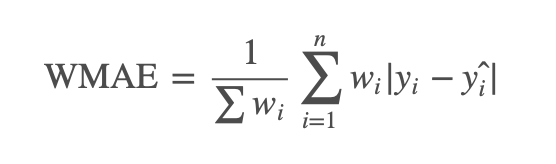

In [ ]:
def wmae(y_pred, targ, holiday_week):
    sumOfWeights = 0
    sumofCol_B_X_Col_E = 0
    
    for i in range(0, len(y_pred)):
        weight = 0
        if holiday_week[i]: 
            weight = 5
        else:
            weight = 1
        
        Col_B_X_Col_E = abs(targ[i] - y_pred[i])*weight
        sumOfWeights += weight 
        sumofCol_B_X_Col_E += Col_B_X_Col_E
    WMAE = sumofCol_B_X_Col_E/sumOfWeights
    return WMAE

Det vi kan se ud fra evalueringen er, at holiday vægtes 5 gange så højt som almindelige dage, hvilket betyder, at jo bedre vi er til at predicte rigtigt på holidays desto bedre score får vi

Vi kan prøve at kigge på, hvor stor forskel der er i salget på en helligdag i forhold til en almindelig dag

In [ ]:
train.groupby("IsHoliday")["Weekly_Sales"].median()

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(train["IsHoliday"],train["Weekly_Sales"])

Forskellen er ikke kæmpe, men der er da lidt forskel

Lad os prøve at se, om typen af butik kunne have indflydelse på salget. I og med nogle butikker er større end andre, vil der nok være en stor forskel

In [ ]:
train.groupby("Type")["Weekly_Sales"].mean()

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(train["Type"],train["Weekly_Sales"])

Ja der er en tydelig sammenhæng mellem butikstype og salg, så dette må være en vigtig feature

Gad vide, hvordan salget har ændret sig gennem årene?

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(train["year"],train["Weekly_Sales"],showfliers=False)

Det ligger godt nok overraskende stabilt! Ud over at vi skal bruge året i forhold til predicte, ser det faktisk ikke ud til at gøre nogen som helst forskel

Lad os kigge på, hvordan de enkelte butikker påvirker resultatet. Her vil et box-plot være godt, fordi det viser minimum, maksimum, 25 percentilen, median og 75 percentilen samtidig 

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(train["Store"],train["Weekly_Sales"],showfliers=False)

Her er der tydeligt meget store individuelle forskelle, sikkert en god kandidat for salget. Hvad med afdelingerne imellem?

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(train["Dept"],train["Weekly_Sales"],showfliers=False)

Også store individuelle forskelle, ikke underligt, men godt at vide

# ** 5. Løs opgaven**

Nu skal vi så have udvalgt de kolonner vi tror mest på. Ud fra vores analyse, må det være: Store, Dept, Type, year, month, day, week, IsHoliday. Så vi laver en feature liste, som vi kan bruge til at udvælge kolonnerne

In [ ]:
feature = ["Store","Dept","year","month","day","week","IsHoliday", "Size"]

In [ ]:
X_train = train[feature]
X_test = test[feature]

In [ ]:
X_train

In [ ]:
y_train = train["Weekly_Sales"]

En god model til at forudsige regression er Random Forest Regressor, som er forklaret her: https://www.youtube.com/watch?v=g9c66TUylZ4 

Desværre ved vi endnu ikke helt, hvad der vil være de bedste features og hyperparametre, men det finder vi ud af

In [ ]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train,y_train, test_size=0.2)

Lad os starte med at sætte antal træer til 10 og dybden til 4 niveauer, bagefter kan vi prøve med GridSearch for at finde det optimale antal

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10,n_jobs=4)


In [ ]:
model.fit(X_train1,y_train1)

Når vi har fitted vores model, kan vi spørge modellen, hvilke features der var de væsentligste i forhold til at opnå et godt resultat

In [ ]:
(pd.DataFrame([X_train.columns,model.feature_importances_],columns=feature).T).plot.bar()

Det er som vi også så i box-plottet helt klart dept, store og type der er de vigtigste, mens holiday ikke spiller nogen rolle. Men vi er nød til at have den med for at kunne lave vores evaluering. Vores evaluering har brug for en liste af predictions, en liste af ground truth og en liste af holidays for samme datoer, så lad os lave en liste af holidays

In [ ]:
holidays = X_test1['IsHoliday'].to_numpy()
y_test1 = y_test1.to_numpy()

og så predicte

In [ ]:
result = model.predict(X_test1)

In [ ]:
WMAE = wmae(result, y_test1, holidays)
print(WMAE)

Er det et godt resultat? Hvis vi kigger på leaderboardet, så er det faktisk en rigtig god score. Faktisk bedre end nummer 1. Men nu har vi jo kun testet på det data vi havde tilgængeligt, så det kan ændre sig, når vi indsender vores resultat. Men der burde være en rimelig god chance. Men vi bør nok afprøve noget cross validation for at være sikker på, at vi ikke bare har været heldige

Så lad os opsætte GridSearchCV

In [ ]:
'''from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10, 100, 200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, n_jobs = 3, verbose = 2)'''



In [ ]:
#grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

Lad os prøve med en anden algoritme nemlig XGBoost. Den er forklaret her: https://www.youtube.com/watch?v=OtD8wVaFm6E
Men ligger ikke i scikit learn, så den skal installeres med pip

In [ ]:
#!pip install xgboost

In [ ]:
import xgboost as xgb

xgboost har brug for noget der kaldes en DataMatrix, så vi må lave vores data om til den type

In [ ]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

Så opsætter vi den med en række hyperparametre. Vi kan prøve GridSearch om lidt for at finde ud af, hvad de bedste parametre er

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
 #               max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train1,y_train1)
result = xg_reg.predict(X_test1)

In [ ]:
WMAE = wmae(result, y_test1, holidays)
print(WMAE)

Det var et ret skidt resultat, lad os prøve at optimere den lidt

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import ShuffleSplit

In [ ]:
'''
xgb1 = xg_reg
parameters = {'nthread':[3], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 3,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)
'''

Lad os lægge os fast på den model vi helst vil bruge. Træne på hele sættet, predicte på testsættet og indsende til kaggle

In [ ]:
'''xg_reg = xgb.XGBRegressor(colsample_bytree= 0.7, learning_rate= 0.07, max_depth= 5, min_child_weight= 4, n_estimators= 300, nthread= 4, objective= 'reg:linear', silent= 1, subsample=0.7)'''

In [ ]:
'''xg_reg.fit(X_train,y_train)

result = xg_reg.predict(X_test)'''

In [ ]:

%%time
from sklearn.ensemble import RandomForestRegressor
#model = RandomForestRegressor(bootstrap= True, max_depth= 110, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, n_estimators= 200)

model = RandomForestRegressor(n_estimators= 500)

model.fit(X_train,y_train)

result = model.predict(X_test)

Modellen blev desværre ikke bedre efter tuning, så jeg må have truffet nogle dårlige valg som input til modellen

In [ ]:
sub = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip")

In [ ]:
sub.head()

In [ ]:
sub["Weekly_Sales"] = result
sub.head()

# ** 7.	Indsend resultatet **

In [ ]:
sub.to_csv("walmart_predict_sub.csv",index=False)